In [108]:
import numpy as np
import mne

In [109]:
import numpy as np

def normalize_eeg(signal):
    """
    Normalize EEG signal using z-score normalization
    
    Parameters:
        signal (array-like): Raw EEG signal
        
    Returns:
        array-like: Normalized EEG signal
    """
    # Z-score normalization: (x - mean) / std
    normalized = (signal - np.mean(signal)) / np.std(signal)
    return normalized

In [110]:
data = np.array(mne.read_epochs(r"C:\Users\mhfar\OneDrive\Desktop\New folder\20second_MNE_2CLASS\Epilepsy\train\aji_epo.fif"))[10]

Reading C:\Users\mhfar\OneDrive\Desktop\New folder\20second_MNE_2CLASS\Epilepsy\train\aji_epo.fif ...
    Found the data of interest:
        t =       0.00 ...   20996.67 ms
        0 CTF compensation matrices available
Not setting metadata
229 matching events found
No baseline correction applied
0 projection items activated


In [111]:
data.shape


(22, 6300)

In [112]:
import numpy as np

data = normalize_eeg(data)

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import pywt

###############################################################################
# 1) NOISE-GENERATION FUNCTION (TRANSIENT HIGH-FREQUENCY BURSTS)
###############################################################################
def add_transient_high_freq_noise(
    eeg_data,
    fs,
    num_bursts=3,
    burst_duration=0.1,
    freq_range=(70, 120),
    amplitude_range=(0.1, 0.3),
    random_seed=None
):
    """
    Add short bursts of high-frequency sinusoidal noise to simulate
    transient muscle artifacts or high-frequency interference.

    Parameters
    ----------
    eeg_data : np.ndarray, shape (n_samples,)
        Original clean EEG (or partially clean) signal.
    fs : float
        Sampling rate in Hz.
    num_bursts : int
        Number of high-frequency noise bursts to add.
    burst_duration : float
        Duration of each noise burst in seconds.
    freq_range : tuple (low_freq, high_freq)
        Range of frequencies (in Hz) to randomly pick for each burst.
    amplitude_range : tuple (low_amp, high_amp)
        Range of amplitudes to randomly pick for each burst.
    random_seed : int or None
        If set, ensures reproducible noise bursts.

    Returns
    -------
    eeg_noisy : np.ndarray, shape (n_samples,)
        EEG signal with added transient high-frequency noise bursts.
    """
    if random_seed is not None:
        np.random.seed(random_seed)
    
    eeg_noisy = eeg_data.copy()
    n_samples = len(eeg_data)
    
    # Calculate number of samples in each burst
    samples_per_burst = int(burst_duration * fs)
    
    for _ in range(num_bursts):
        # Random start index for burst
        start_idx = np.random.randint(0, n_samples - samples_per_burst)
        end_idx = start_idx + samples_per_burst
        
        # Random frequency and amplitude
        freq = np.random.uniform(freq_range[0], freq_range[1])
        amp = np.random.uniform(amplitude_range[0], amplitude_range[1])
        
        # Generate time for the burst
        t_burst = np.linspace(0, burst_duration, samples_per_burst, endpoint=False)
        
        # Create a sinusoidal burst
        phase = 2 * np.pi * np.random.rand()  # random initial phase
        burst_signal = amp * np.sin(2 * np.pi * freq * t_burst + phase)
        
        # Optional: shape the burst with a smooth window to avoid sharp edges
        # For example, a half-cosine ramp at start and end:
        window_len = max(1, samples_per_burst // 4)
        ramp_up = (1 - np.cos(np.linspace(0, np.pi, window_len))) / 2
        ramp_down = (1 - np.cos(np.linspace(np.pi, 2*np.pi, window_len))) / 2
        
        burst_signal[:window_len] *= ramp_up
        burst_signal[-window_len:] *= ramp_down[::-1]
        
        # Add the burst to eeg_noisy
        eeg_noisy[start_idx:end_idx] += burst_signal
    
    return eeg_noisy

###############################################################################
# 2) FILTERING FUNCTIONS
###############################################################################
def bandpass_filter(signal, fs, lowcut=1.0, highcut=40.0, order=4):
    """
    Apply a Butterworth bandpass filter to a 1D signal.
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    
    b, a = butter(order, [low, high], btype='band')
    filtered = filtfilt(b, a, signal)
    return filtered

def wavelet_denoise(signal, wavelet='db4', level=2):
    """
    Wavelet-based denoising for a 1D signal using PyWavelets.
    """
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    
    # Simple universal threshold
    threshold = np.sqrt(2 * np.log(len(signal))) * (np.median(np.abs(coeffs[-1])) / 0.6745)
    
    # Apply soft threshold to all detail coefficients
    new_coeffs = []
    for i, c in enumerate(coeffs):
        if i == 0:
            # Approximation coefficients are not thresholded
            new_coeffs.append(c)
        else:
            # Detail coefficients are thresholded
            new_coeffs.append(pywt.threshold(c, threshold, mode='soft'))
    
    denoised = pywt.waverec(new_coeffs, wavelet)
    
    # Match original length
    if len(denoised) != len(signal):
        denoised = denoised[: len(signal)]
    
    return denoised

###############################################################################
# 3) MAIN DEMO - USAGE EXAMPLE
###############################################################################
def main(true_signal):
    #--------------------------------------------------------------------------
    # STEP A: Load your own EEG data (single channel, shape=(n_samples,))
    #         For demonstration, we'll create a synthetic signal.
    #--------------------------------------------------------------------------
    fs = 250.0       # Sampling rate in Hz
    n_samples = 600  # e.g., 300 time points
    time = np.linspace(0, n_samples/fs, n_samples, endpoint=False)
    
    # Example: a 10 Hz sinusoid + mild random noise
    
    base_noise = 0.05 * np.random.randn(n_samples)
    eeg_data = true_signal + base_noise
    
    #--------------------------------------------------------------------------
    # STEP B: Add short bursts of transient high-frequency noise
    #--------------------------------------------------------------------------
    eeg_noisy = add_transient_high_freq_noise(
        eeg_data,
        fs,
        num_bursts=1,
        burst_duration=0.4,       # 50 ms bursts
        freq_range=(70, 180),      # random freq in [70, 120] Hz
        amplitude_range=(0.2, 0.8),# random amplitude in [0.2, 0.4]
        random_seed=42             # for reproducibility
    )

    #--------------------------------------------------------------------------
    # STEP C: Filter & Denoise
    #
    # 1) Bandpass Filter: e.g., 1-40 Hz
    # 2) Wavelet Denoise
    #--------------------------------------------------------------------------
    eeg_bandpassed = bandpass_filter(eeg_noisy, fs, lowcut=1.0, highcut=80.0, order=4)
    eeg_denoised = wavelet_denoise(eeg_bandpassed, wavelet='db4', level=2)

    #--------------------------------------------------------------------------
    # STEP D: Plot the results
    #--------------------------------------------------------------------------
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    
    
    
    axs[0].plot(time, eeg_noisy, 'r')
    axs[0].set_title("Raw EEG")
    axs[0].legend(loc='upper right')
    axs[0].set_ylabel("Amplitude")
    
    axs[1].plot(time, eeg_denoised, 'b')
    axs[1].set_title("Denoised EEG [1 to 80 Hz Bandpass + 50 Hz Notch]")
    axs[1].legend(loc='upper right')
    axs[1].set_xlabel("Time (s)")
    axs[1].set_ylabel("Amplitude")
    
    plt.tight_layout()
    plt.savefig('filtered eeg', dpi = 600)
    plt.show()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


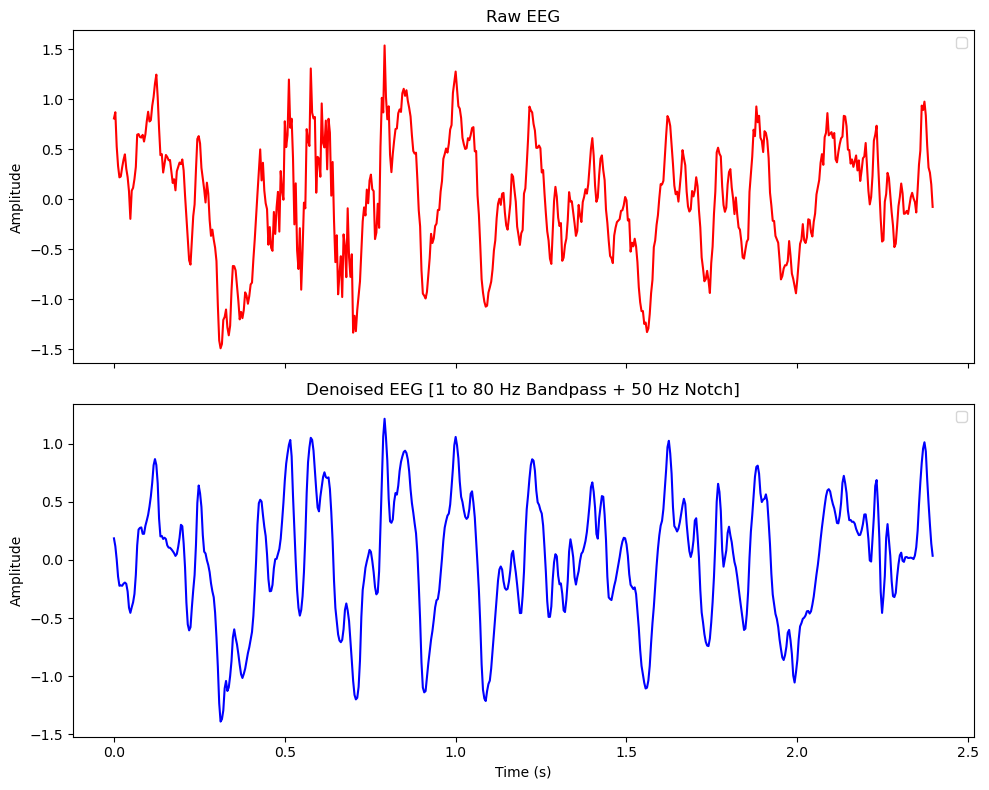

In [114]:
eeg_raw = data[14, 2100:2700]
if __name__ == "__main__":
    main(eeg_raw)